In [1]:
from datetime import datetime
import numpy as np
import os
os.environ['MPLCONFIGDIR'] = "/wrk-vakka/users/hajaalin/tmp_mplconfigdir"
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from pathlib import Path
import shap
import sys



/proj/group/lmu/software/Miniconda3/py38_4.12.0/envs/tsc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#shap_root = Path('/proj/group/lmu/projects/n_track_ML/output/shap/save_X_test_f_dxy_mindist_angle_area_20221103/202211030938/')
shap_root = Path('/wrk/group/lmu/projects/n_track_ML/output/shap/save_X_test2_f_dxy_mindist_angle_area_20221103/202211031451/')
glob3 = shap_root.glob('*/train_index_list.npy')
glob4 = shap_root.glob('*/accuracy_list.npy')
  
load_train_index_list = []
for g in glob3:
    #print(str(g))
    load_train_index_list.extend(np.load(g, allow_pickle=True))

load_accuracy_list = []
for g in glob4:
    #print(str(g))
    load_accuracy_list.extend(np.load(g, allow_pickle=True))



In [3]:
print(len(load_train_index_list))
print(load_train_index_list[0].shape)
print(len(load_accuracy_list))
print(load_accuracy_list[0].shape)


10000
(216,)
10000
()


## Histogram of accuracy

(array([   2.,    2.,    5.,    3.,   12.,   17.,   29.,   44.,   57.,
          45.,   99.,  145.,  171.,  175.,  171.,  231.,  224.,  173.,
         224.,  159.,  155.,  115.,   93.,   51.,   52.,   28.,   20.,
          21.,   19.,   10.,   26.,   40.,   30.,   35.,   70.,   95.,
         107.,  159.,  195.,  226.,  314.,  302.,  396.,  427.,  592.,
         657.,  717.,  849., 1029., 1182.]),
 array([0.375 , 0.3875, 0.4   , 0.4125, 0.425 , 0.4375, 0.45  , 0.4625,
        0.475 , 0.4875, 0.5   , 0.5125, 0.525 , 0.5375, 0.55  , 0.5625,
        0.575 , 0.5875, 0.6   , 0.6125, 0.625 , 0.6375, 0.65  , 0.6625,
        0.675 , 0.6875, 0.7   , 0.7125, 0.725 , 0.7375, 0.75  , 0.7625,
        0.775 , 0.7875, 0.8   , 0.8125, 0.825 , 0.8375, 0.85  , 0.8625,
        0.875 , 0.8875, 0.9   , 0.9125, 0.925 , 0.9375, 0.95  , 0.9625,
        0.975 , 0.9875, 1.    ]),
 <BarContainer object of 50 artists>)

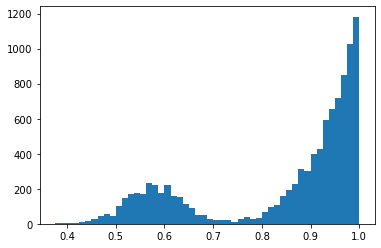

In [4]:
accuracy = np.array(load_accuracy_list)
plt.hist(accuracy, bins=50)

## Limits for hi and lo accuracy models
25% seems to be a good pick. The least accurate 25% accounts for the bump centered at 0.57 or so.

In [5]:
acc_lo = np.percentile(accuracy, 25)
acc_hi = np.percentile(accuracy, 75)
print(acc_lo)
print(acc_hi)


0.7123287671232876
0.9726027397260274


In [6]:
load_train_index_list[0]

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  14,  17,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  31,  32,  35,
        36,  37,  38,  39,  40,  43,  44,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  58,  59,  61,  62,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  78,  79,  80,  81,  86,  87,  88,  91,
        92,  93,  94,  95,  96,  97,  98, 103, 104, 105, 106, 107, 108,
       109, 110, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 127, 128, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 145, 146, 147, 148, 149, 150, 153, 154, 155, 156, 157,
       158, 161, 162, 163, 164, 165, 166, 167, 168, 173, 174, 175, 176,
       177, 180, 181, 182, 183, 184, 185, 186, 187, 190, 191, 192, 193,
       196, 197, 198, 199, 202, 203, 204, 205, 206, 209, 210, 211, 212,
       213, 214, 217, 218, 219, 220, 223, 224, 225, 226, 227, 228, 229,
       230, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 24

In [7]:
load_train_index_list[1].shape

(223,)

In [8]:
accuracy > acc_hi


array([False, False, False, ..., False, False,  True])

## Convert training set index in binary format
[1,3,4,7,...] -> [1,0,1,1,0,0,1,...]

In [9]:
def index_to_boolean(integer_index):
    idx = np.zeros(289)
    for i in integer_index:
        idx[i] = 1
    return idx

index_list = []
for index in load_train_index_list:
    index_list.append(index_to_boolean(index))

index_list = np.array(index_list)
index_list.shape

(10000, 289)

## Sum over repetitions to see how many times a sequence appears in the training set
### First all repetitions...

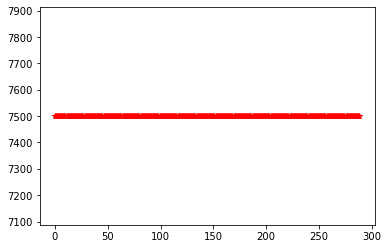

In [10]:
index_sums = np.sum(index_list, axis=(0) )
plt.plot(index_sums, '*', color='r')


### ... and then repetitions that ended up with a hi or lo accuracy model

In [11]:
index_list_hi = index_list[ accuracy > acc_hi ]
index_list_lo = index_list[ accuracy < acc_lo ]
index_sums_hi = np.sum(index_list_hi, axis=(0))
index_sums_lo = np.sum(index_list_lo, axis=(0))


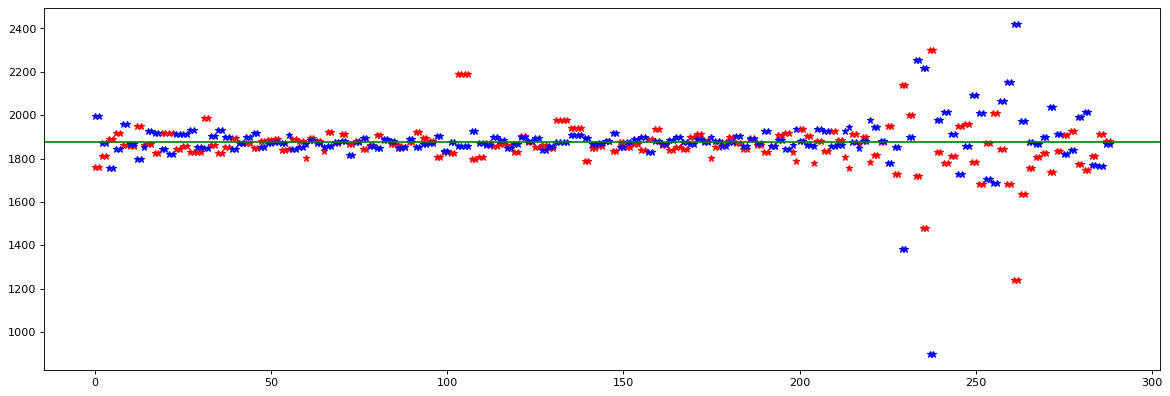

In [12]:
plt.figure(figsize = (18, 6), dpi = 80)
plt.plot(index_sums_hi, '*', color='r')
plt.plot(index_sums_lo, '*', color='b')
plt.axhline(y = 1875, color = 'g', linestyle = '-')
#plt.plot(7500/4)

In [13]:
diff_sums = index_sums_hi - index_sums_lo

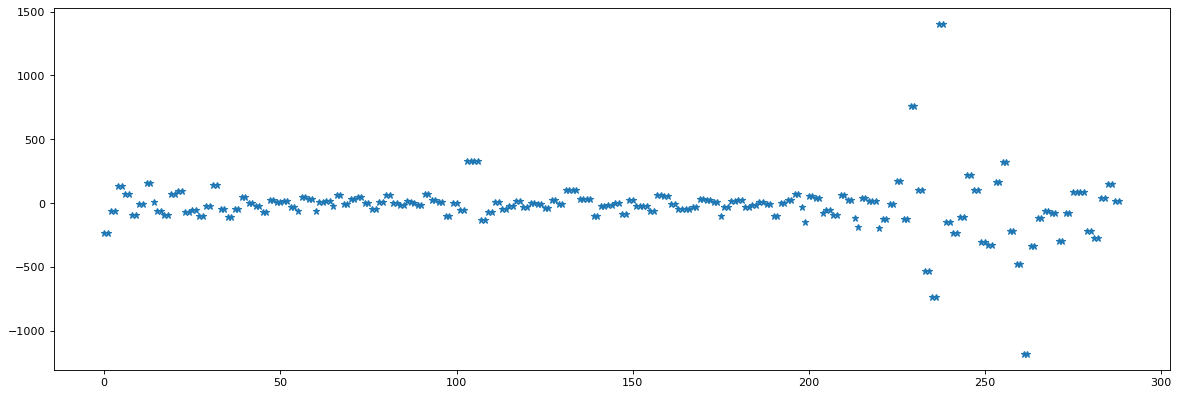

In [14]:
plt.figure(figsize = (18, 6), dpi = 80)
plt.plot(diff_sums, '*')

In [15]:
7500/4

1875.0

In [16]:
img_sums_hi = index_sums_hi.copy()
img_sums_lo = index_sums_lo.copy()
print(np.min(img_sums_hi))
print(np.min(img_sums_lo))
min(np.min(img_sums_hi), np.min(img_sums_lo))

1240.0
900.0


900.0

In [17]:
img_sums_hi = index_sums_hi.copy()
img_sums_lo = index_sums_lo.copy()
sum_min = min(np.min(img_sums_hi), np.min(img_sums_lo))
sum_max = max(np.max(img_sums_hi), np.max(img_sums_lo))
print(sum_min)
print(sum_max)
img_sums_hi = (img_sums_hi - sum_min) / sum_max
img_sums_lo = (img_sums_lo - sum_min) / sum_max
img_sums_hi.resize(300)
img_sums_lo.resize(300)
img_sums_hi = img_sums_hi.reshape((15,20))
img_sums_lo = img_sums_lo.reshape((15,20))

# https://stackoverflow.com/questions/10443295/combine-3-separate-numpy-arrays-to-an-rgb-image-in-python
r = img_sums_hi
g = np.zeros((15,20))
b = img_sums_lo

rgb = np.dstack((r,g,b))
rgb_uint8 = (np.dstack((r,g,b)) * 255.999) .astype(np.uint8)

900.0
2419.0


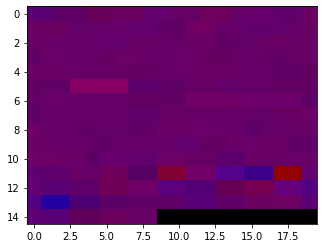

In [18]:
#plt.imshow(rgb_uint8)
#plt.rcParams["figure.figsize"] = (15,20)
plt.imshow(rgb)


In [19]:
ish = index_sums_hi[index_sums_hi > 1875]

In [20]:
ish.shape

(120,)

# Fold accuracy

For some reason, fold 1/4 seems to consistently result in lower accuracy. 
- Something wrong with StratifiedGroupKFold? Test with KFold to compare.

## Accuracy of folds 1-4, 2500 repetitions

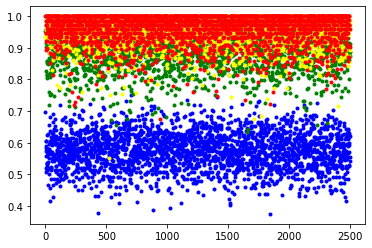

In [21]:
accarr = np.array(load_accuracy_list)
a1 = accarr[0:9999:4]
a2 = accarr[1:9999:4]
a3 = accarr[2:9999:4]
a4 = accarr[3:9999:4]
plt.plot(a1,'.', color='blue')
plt.plot(a2,'.', color='green')
plt.plot(a3,'.', color='yellow')
plt.plot(a4,'.', color='red')

## How often an instance ended up in a particular fold?
- Why not uniform throughout?

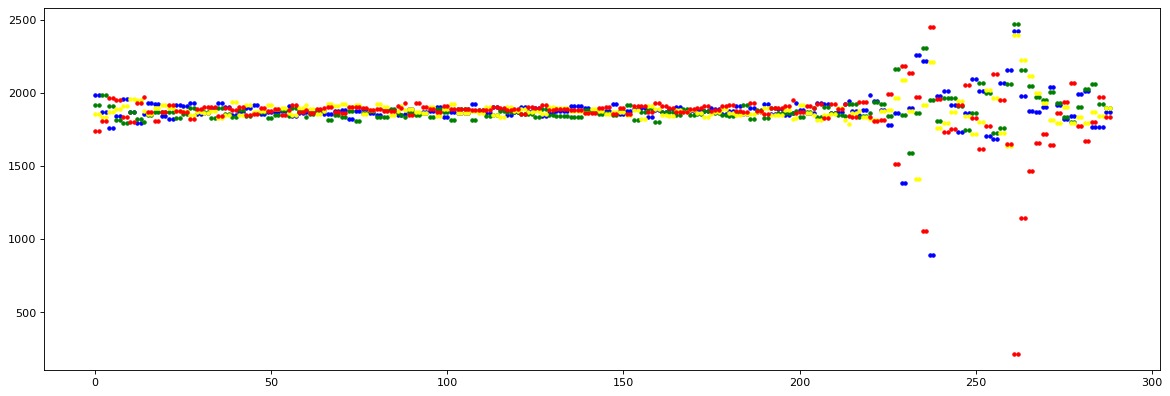

In [32]:

index_sums = np.sum(index_list, axis=(0) )
index_sums1 = np.sum(index_list[0:9999:4], axis=(0) )
index_sums2 = np.sum(index_list[1:9999:4], axis=(0) )
index_sums3 = np.sum(index_list[2:9999:4], axis=(0) )
index_sums4 = np.sum(index_list[3:9999:4], axis=(0) )
plt.figure(figsize = (18, 6), dpi = 80)
#plt.plot(index_sums, '.', color='black')
plt.plot(index_sums1, '.', color='blue')
plt.plot(index_sums2, '.', color='green')
plt.plot(index_sums3, '.', color='yellow')
plt.plot(index_sums4, '.', color='red')


## Fold 1 is practically identical with the least accurate 25%

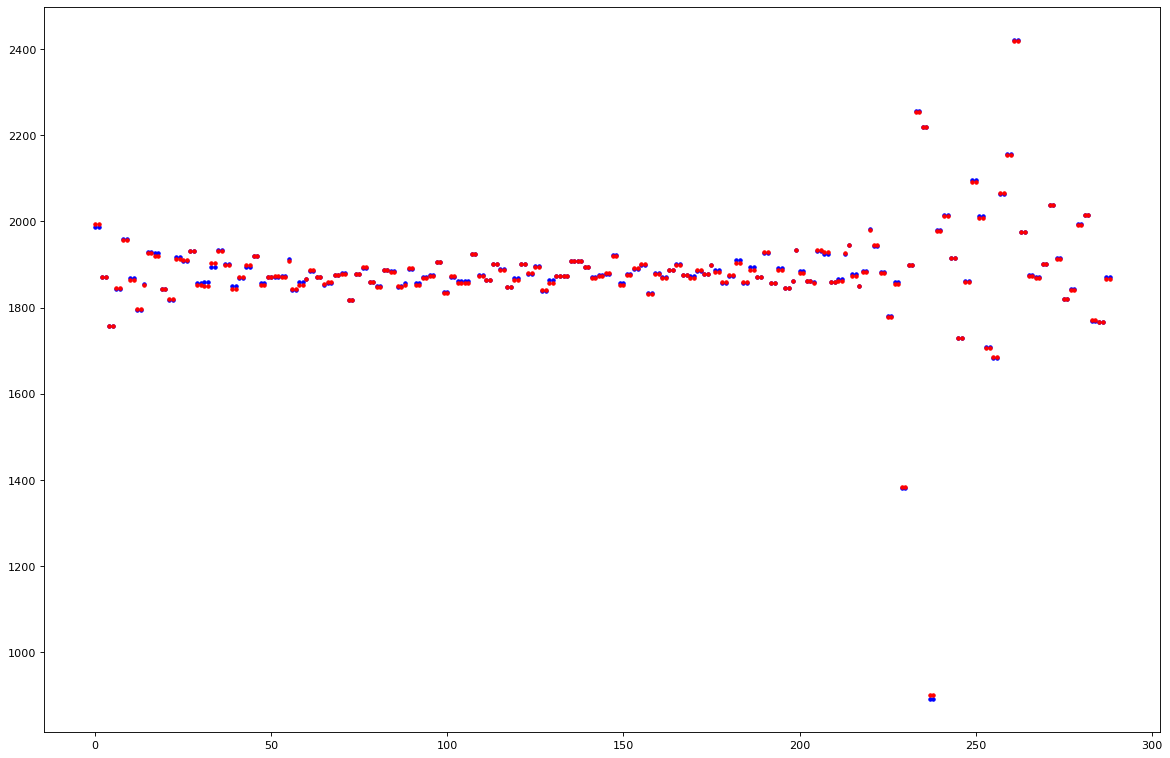

In [37]:
plt.figure(figsize = (18, 12), dpi = 80)
plt.plot(index_sums1, '.', color='blue')
plt.plot(index_sums_lo, '.', color='red')


In [23]:
print(index_list.shape)
print(index_list[0:9999:4].shape)
print(index_list[1:9999:4].shape)
print(index_list[2:9999:4].shape)
print(index_list[3:9999:4].shape)


(10000, 289)
(2500, 289)
(2500, 289)
(2500, 289)
(2499, 289)


In [ ]:
## Class distribution

In [39]:
y = np.load('/wrk-vakka/group/lmu/projects/n_track_ML/output/shap/shap_inceptiontime/20221117140251/y_mean.npy')
print(y.shape)
print(y)

(289,)
[0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 1 1
 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1
 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1
 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1]


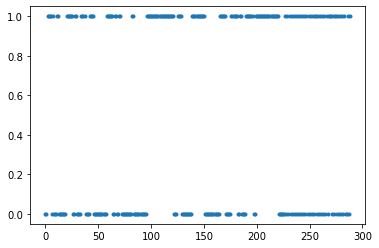

In [40]:
plt.plot(y, '.')